In [5]:
list.of.packages = c('randomForest', 'mvtnorm','tidyverse')
new.packages = list.of.packages[!(list.of.packages 
                    %in% installed.packages()[,"Package"])]
if(length(new.packages)) install.packages(
    new.packages,repos='http://cran.us.r-project.org')

options(warn=-1)
suppressWarnings(library(randomForest, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(mvtnorm, quietly = TRUE, warn.conflicts = FALSE))
suppressWarnings(library(tidyverse, quietly = TRUE, warn.conflicts = FALSE))
    

randomForest 4.6-12
Type rfNews() to see new features/changes/bug fixes.


In this module we will see how to correct for the bias when using machine learning tools to estimate causal parameters.

Consider the canonical example: $Y = D\theta_0 + g_0(Z) + U$ and $D=m_0(Z)+V$

We have some binary treatment variable $D$ that is additively separable from the controls $Z$.

Lets generate some data where $g_0=cos(Z)$ and $m_0=sin(Z)$

In [6]:
set.seed(271828)
N=1000
k=10
theta=0.5
tmp = rnorm(100)
tmp = matrix(tmp,c(10,10))
sigma = tmp%*%t(tmp)             
b = as.vector(runif(10))
z = rmvnorm(N,sigma=sigma)       
# Generate the control variables
g = as.vector(cos(z%*%b))           
# g_function 
m = as.vector(sin(z%*%b))         
# m_function
d = m+rnorm(N)                
# variable of interest
y = theta*d+g+rnorm(N)        
# outcome

If we directly estimate $Y$ on $D$ and $g(Z)$ the estimate for $\theta$ will be biased.


The naive estimation method is a two-step procedure, but convergence is very fast.
First you get an initial value for the treatment effect parameter via a regression $y$ on $D$
Once you have this initial value you can build your prediction model and estimate $\hat{g}$.

Iterate back and forth until $\hat{\theta}$ achieves desired stability

In [19]:

TE = array(0,dim=c(500))                            
# Placeholder for treatment effect coefficient
pb = txtProgressBar(min = 0, max = 500, style = 3)

for (i in 1:500){
    Sys.sleep(0.1)

    eps = 1
    c = 0
    while (eps>1e-1){
      if (c==0){
        dhat = coef(lm(y~d+0))[1]                     
          # Initialize theta
        target = y - d*dhat                          
          # residual based on estimate for theta
        model = randomForest(z,y,                    
                maxnodes = 10, ntree = 100)          
          # build the model for the g function
        G_new = predict(model,z)                      
        target = y-G_new                             
          # residual based on estimate for g
        OLS_new = coef(lm(target~d+0))[1]               
      }
      target = y - d*OLS_new
      model = randomForest(z,target,
                           maxnodes = 10, ntree = 100)
      G_old = predict(model,z)
      target = y-G_old
      OLS_old = coef(lm(target~d+0))[1]

      eps = abs(OLS_new-OLS_old)                    
        # Check stability of parameters
      OLS_new = OLS_old                             
        # Updates
      G_new = G_old
    }
    setTxtProgressBar(pb, i)
    TE[i] = OLS_new
}
close(pb)


  |======================================================================| 100%


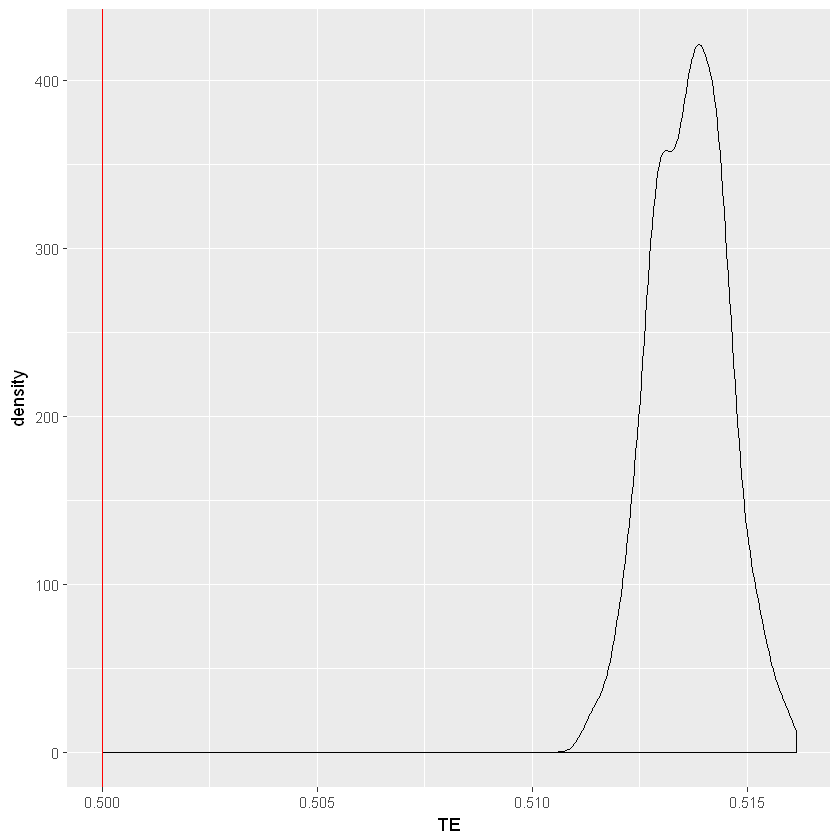

In [20]:
ggplot(data.frame(TE), aes(TE)) + geom_density() + 
    geom_vline(xintercept = 0.5,color='red')

Clearly the estimate here is biased. This isn't terribly surprising as we are ignoring $m$ completely.

A step in the right direction is to estimate $m$ and $g$ in a first-stage and then estimate the treatment effect from the residuals.

First, we can build a prediction model and estimate the $g$ and $m$ functions. Once we have these, we can get the estimate for $\hat{\theta}$ by regressing $y-\hat{g}$ on $d-\hat{m}$


In [23]:

TE = array(0,dim=c(500))
pb = txtProgressBar(min = 0, max = 500, style = 3)

for (i in 1:500){
    Sys.sleep(0.1)

    model_dz = randomForest(z,d,maxnodes = 10, ntree = 100)
    model_yz = randomForest(z,y,maxnodes = 10, ntree = 100)

    G_old = predict(model_yz,z)
    M_old = predict(model_dz,z)

    target_w = y-G_old
    explain_v = d-M_old
    OLS = coef(lm(target_w~explain_v+0))[1]
    setTxtProgressBar(pb, i)

    TE[i] = OLS
}

close(pb)

  |======================================================================| 100%


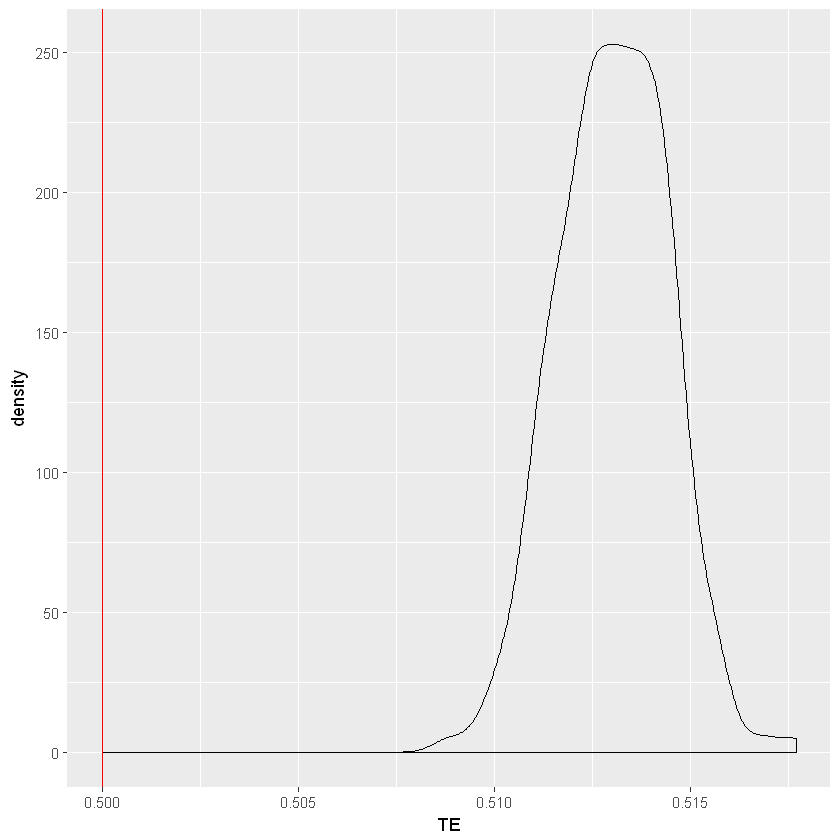

In [24]:
ggplot(data.frame(TE), aes(TE)) + geom_density() + 
geom_vline(xintercept = 0.5,color='red')

The estimates are still biased, though not as badly.

It turns out that we can solve this by splitting our sample.

The idea is to use the estimates for $m$ and $g$ obtained on different partions of the sample to compute the estimate of $\hat{\theta}$.

In [25]:

TE = array(0,dim=c(500))
pb = txtProgressBar(min = 0, max = 500, style = 3)

for (i in 1:500){
    Sys.sleep(0.1)

    I=sort(sample(1:N,N/2))
    Ic=setdiff(1:N,I)

    model_dz1 = randomForest(z[I,],d[I],maxnodes = 10, ntree = 100)
    model_dz2 = randomForest(z[Ic,],d[Ic],maxnodes = 10, ntree = 100)

    model_yz1 = randomForest(z[I,],y[I],maxnodes = 10, ntree = 100)
    model_yz2 = randomForest(z[Ic,],y[Ic],maxnodes = 10, ntree = 100)

    G_old1 = predict(model_yz1,z[I,])
    G_old2 = predict(model_yz2,z[Ic,])

    M_old1 = predict(model_dz1,z[I,])
    M_old2 = predict(model_dz2,z[Ic,])

    target_w1 = y-G_old1
    target_w2 = y-G_old2

    explain_v1 = d-M_old1
    explain_v2 = d-M_old2

    OLS_old1 = coef(lm(target_w2~explain_v1+0))[1]
    OLS_old2 = coef(lm(target_w1~explain_v2+0))[1]
    OLS = mean(cbind(OLS_old1,OLS_old2))
    
    setTxtProgressBar(pb, i)

    TE[i] = OLS
}
close(pb)


  |======================================================================| 100%


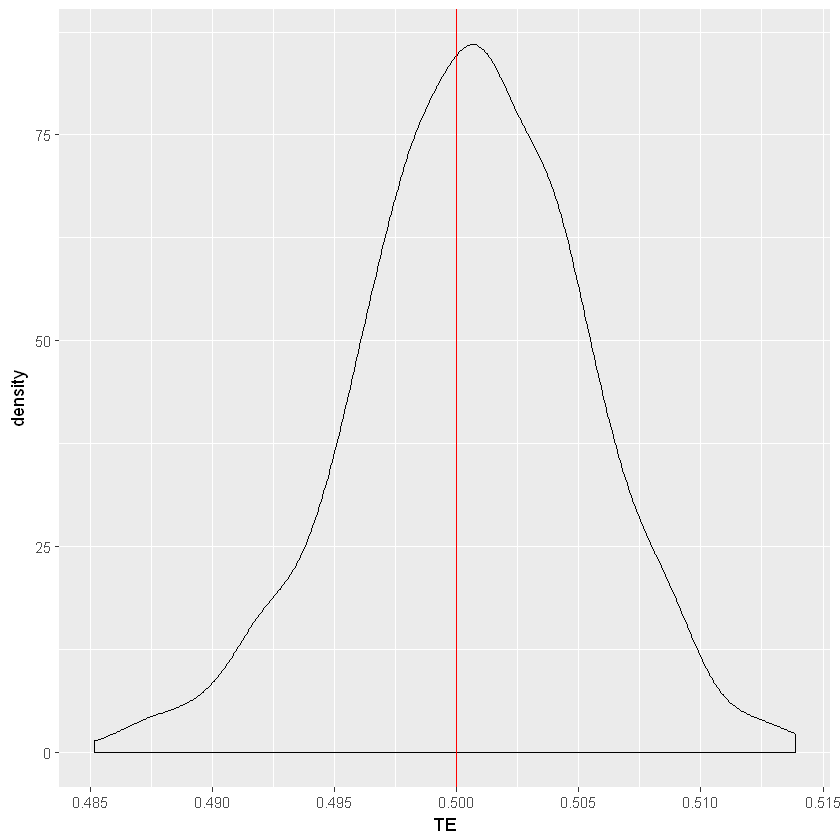

In [26]:
ggplot(data.frame(TE), aes(TE)) + geom_density() + 
geom_vline(xintercept = 0.5,color='red')

This strategy works quite well as the bias is almost completely eliminated.

Naturally the estimator will have a larger variance as it only uses half of the sample. However, one can employ other methods to reduce the dispersion of the estimator.

EXERCISE:

Change the tuning parameters (maxnodes, numtrees, etc) for the random forests in the double-ML estimator. How does this effect the results?

  |======================================================================| 100%


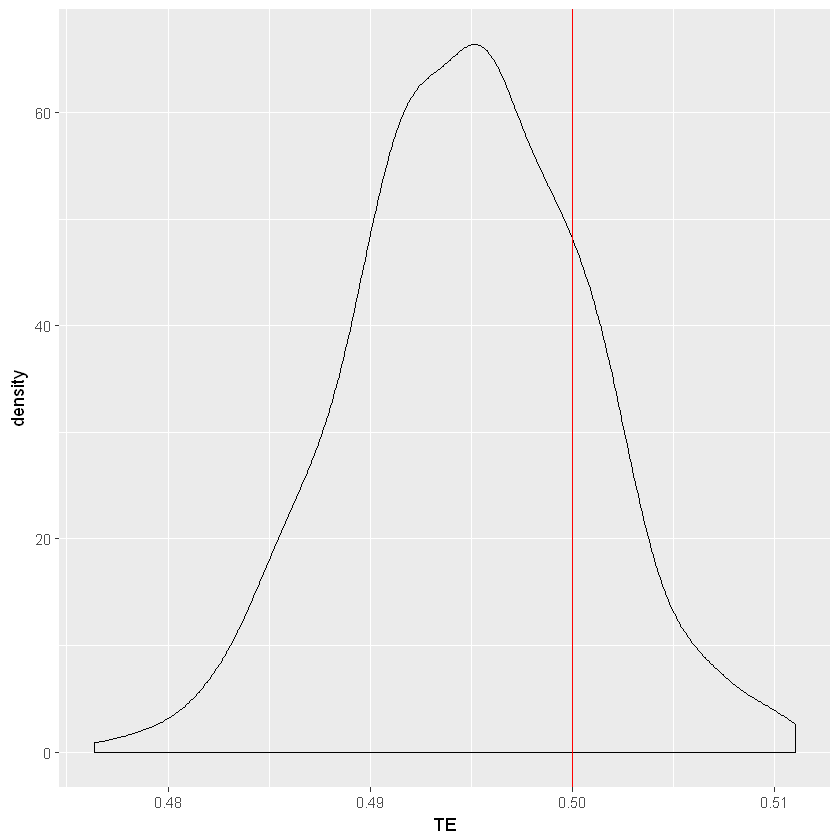

In [27]:

TE = array(0,dim=c(500))
pb = txtProgressBar(min = 0, max = 500, style = 3)

for (i in 1:500){
    Sys.sleep(0.1)

    I=sort(sample(1:N,N/2))
    Ic=setdiff(1:N,I)

    model_dz1 = randomForest(z[I,],d[I],maxnodes = 15, ntree = 200)
    model_dz2 = randomForest(z[Ic,],d[Ic],maxnodes = 15, ntree = 200)

    model_yz1 = randomForest(z[I,],y[I],maxnodes = 15, ntree = 200)
    model_yz2 = randomForest(z[Ic,],y[Ic],maxnodes = 15, ntree = 200)

    G_old1 = predict(model_yz1,z[I,])
    G_old2 = predict(model_yz2,z[Ic,])

    M_old1 = predict(model_dz1,z[I,])
    M_old2 = predict(model_dz2,z[Ic,])

    target_w1 = y-G_old1
    target_w2 = y-G_old2

    explain_v1 = d-M_old1
    explain_v2 = d-M_old2

    OLS_old1 = coef(lm(target_w2~explain_v1+0))[1]
    OLS_old2 = coef(lm(target_w1~explain_v2+0))[1]
    OLS = mean(cbind(OLS_old1,OLS_old2))
    
    setTxtProgressBar(pb, i)

    TE[i] = OLS
}
close(pb)

ggplot(data.frame(TE), aes(TE)) + geom_density() + 
geom_vline(xintercept = 0.5,color='red')